In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import spacy
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model  import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from collections import defaultdict
import en_core_web_md

nlp = en_core_web_md.load()

In [2]:
#Read in data, treat Date as a string so that 0X does not turn into X for day
usa_china_df = pd.read_csv('data/usa_china_text_data.csv', dtype = {'Date': str})
usa_canada_df = pd.read_csv('data/usa_canada_text_data.csv', dtype = {'Date': str})
china_canada_df = pd.read_csv('data/china_canada_text_data.csv', dtype = {'Date': str})

#strip newline characters that were appearing
china_canada_df['Source'] = china_canada_df['Source'].str.strip()

#Drop NaNs that occurred
usa_china_df = usa_china_df.dropna(subset=['Content'])
usa_canada_df = usa_canada_df.dropna(subset=['Content'])
china_canada_df = china_canada_df.dropna(subset=['Content'])

#convert date to datetime format and add month column to calculate monthly sentiment
usa_china_df['Date'] = pd.to_datetime(usa_china_df['Date'], format='%d%m%y')
usa_china_df['Month'] = usa_china_df['Date'].dt.to_period('M')

usa_canada_df['Date'] = pd.to_datetime(usa_canada_df['Date'], format='%d%m%y')
usa_canada_df['Month'] = usa_canada_df['Date'].dt.to_period('M')

#assign 28th of February since leap year 29th is not in datetime
china_canada_df.loc[23, 'Date'] = '280225'
china_canada_df['Date'] = pd.to_datetime(china_canada_df['Date'], format='%d%m%y')
china_canada_df['Month'] = china_canada_df['Date'].dt.to_period('M')

usa_china_df.head()


,Date,Title,Content,Source,Month
0,2025-07-12,On the 9th Anniversary of the Philippines-Chin...,"Nine years ago, an Arbitral Tribunal constitut...",USA,2025-07
1,2025-07-11,Secretary of State Marco Rubio Remarks to the ...,SECRETARY RUBIO: We had a great visit – great ...,USA,2025-07
2,2025-07-11,Secretary of State Marco Rubio Remarks to the ...,SECRETARY RUBIO: You guys don’t look nearly a...,USA,2025-07
3,2025-07-11,Secretary Rubio’s Meeting with China’s Directo...,The below is attributable to Spokesperson Tamm...,USA,2025-07
4,2025-07-08,"Department Press Briefing – July 8, 2025",QUESTION: On – there was this press conference...,USA,2025-07


In [3]:
#tokenizer and remove filler/stop words and non alphabetic characters
from spacy.lang.en import English
en = English()
n = 10 #top 10 words

def simple_tokenizer(doc, model=en):
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])

#TF-IDF Vectorization with unigrams
tfidf_text_content = TfidfVectorizer(tokenizer = simple_tokenizer, token_pattern = None, ngram_range=(1,1))


#USA and China
tfidf_text_content_vecs = tfidf_text_content.fit_transform(usa_china_df['Content']).toarray()
#returns filter names identified by TF-IDF vectorizer
#filter so that the source is USA articles, sum by column over all USA documents
#creates dictionary for top words and their TF-IDF score
tfidf_count_text_content_usa_to_china = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[usa_china_df['Source'] == 'USA'].sum(axis = 0)))
print('Top ten words used in USA-China relations by USA (TF-IDF):')
print(sorted(tfidf_count_text_content_usa_to_china.items(), key=lambda x: x[1], reverse=True)[:n], end='\n\n')

tfidf_count_text_content_china_to_usa = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[usa_china_df['Source'] == 'China'].sum(axis = 0)))
print('Top ten words used in USA-China relations by China (TF-IDF):')
print(sorted(tfidf_count_text_content_china_to_usa.items(), key=lambda x: x[1], reverse=True)[:n], end='\n\n')

#USA and Canada
tfidf_text_content_vecs = tfidf_text_content.fit_transform(usa_canada_df['Content']).toarray()
tfidf_count_text_content_usa_to_canada = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[usa_canada_df['Source'] == 'USA'].sum(axis = 0)))
print('Top ten words used in USA-Canada relations by USA (TF-IDF):')
print(sorted(tfidf_count_text_content_usa_to_canada.items(), key=lambda x: x[1], reverse=True)[:n], end='\n\n')

tfidf_count_text_content_canada_to_usa = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[usa_canada_df['Source'] == 'Canada'].sum(axis = 0)))
print('Top ten words used in USA-Canada relations by Canada (TF-IDF):')
print(sorted(tfidf_count_text_content_canada_to_usa.items(), key=lambda x: x[1], reverse=True)[:n], end='\n\n')

#China and Canada
tfidf_text_content_vecs = tfidf_text_content.fit_transform(china_canada_df['Content']).toarray()
tfidf_count_text_content_china_to_canada = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[china_canada_df['Source'] == 'China'].sum(axis = 0)))
print('Top ten words used in China-Canada relations by China (TF-IDF):')
print(sorted(tfidf_count_text_content_china_to_canada.items(), key=lambda x: x[1], reverse=True)[:n], end='\n\n')

tfidf_count_text_content_canada_to_china = dict(zip(tfidf_text_content.get_feature_names_out(), tfidf_text_content_vecs[china_canada_df['Source'] == 'Canada'].sum(axis = 0)))
print('Top ten words used in China-Canada relations by Canada (TF-IDF):')
print(sorted(tfidf_count_text_content_canada_to_china.items(), key=lambda x: x[1], reverse=True)[:n], end='\n\n')

#save dictionaries in an overall dictionary
tfidf_dicts = {'USA-China': tfidf_count_text_content_usa_to_china,
              'China-USA': tfidf_count_text_content_china_to_usa,
              'USA-Canada': tfidf_count_text_content_usa_to_canada,
              'Canada-USA': tfidf_count_text_content_canada_to_usa,
              'China-Canada': tfidf_count_text_content_china_to_canada,
              'Canada-China': tfidf_count_text_content_canada_to_china}


Top ten words used in USA-China relations by USA (TF-IDF):
[('secretary', 3.416907265059992), ('china', 2.9557522350486427), ('question', 2.8475275588250026), ('rubio', 2.7323854873000655), ('going', 2.4388661932193862), ('iran', 2.1821677180160477), ('chinese', 2.062254299730788), ('states', 1.9919191770430558), ('bruce', 1.9853780313459912), ('president', 1.933671115844641)]

Top ten words used in USA-China relations by China (TF-IDF):
[('china', 13.400747944428133), ('relations', 5.805258088314767), ('xi', 5.004042084937861), ('president', 4.7723511757204085), ('cooperation', 4.749948910603949), ('states', 4.730181966935556), ('united', 4.670886025579755), ('development', 4.486058782622221), ('countries', 4.133976167378458), ('sides', 4.1036679228519715)]

Top ten words used in USA-Canada relations by USA (TF-IDF):
[('rubio', 2.4429236516796022), ('secretary', 2.299747000856435), ('canada', 1.716387707080005), ('president', 1.4242711553828786), ('united', 1.398209275889897), ('bruce

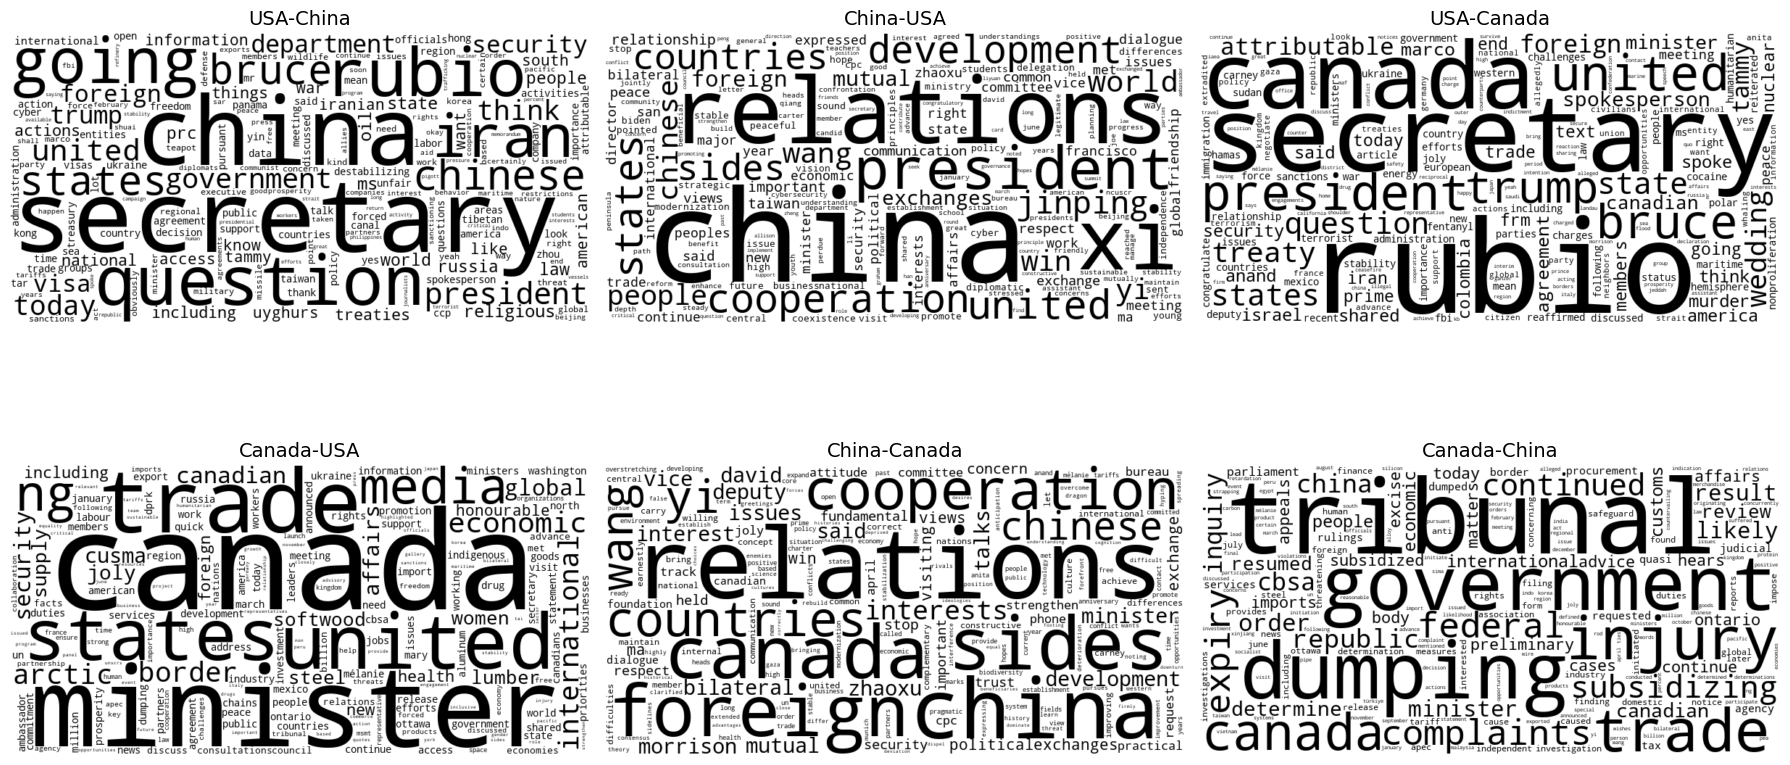

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Number of word clouds to show
n = len(tfidf_dicts)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))

# Flatten axes in case of multiple rows
axs = axs.flatten()

for idx, (pair, tfidf_dict) in enumerate(tfidf_dicts.items()):
    wc = WordCloud(width=800, height=400, background_color='white', color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_dict)
    axs[idx].imshow(wc, interpolation='bilinear')
    axs[idx].axis('off')
    axs[idx].set_title(pair, fontsize=14)

# Hide any unused subplots
for j in range(idx + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [4]:
#Get sentiment of words from dictionaries
#Use opinion lexicon from NLTK, Natural Language Toolkit, identifies words as positive or negative

#potential issues: all are weighted the same, no difference between very negative/slightly negative, etc.

from nltk.corpus import opinion_lexicon
from nltk.sentiment.util import mark_negation
from nltk.corpus import sentiwordnet as swn
import nltk
nltk.download('opinion_lexicon')

#get words that are positive or negative
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

'''
#identify whether words in a dictionary are marked positive or negative
def label_sentiment_words(tfidf_dict):
    sentiment_labels = {}
    for word in tfidf_dict:
        if word in positive_words:
            sentiment_labels[word] = "positive"
        elif word in negative_words:
            sentiment_labels[word] = "negative"
        else:
            sentiment_labels[word] = "neutral"
    return sentiment_labels

#stores dictionaries of the words identified as positive, negative, or neutral
sentiment_labels = {}

for relation, tfidf_dict in tfidf_dicts.items():
    label = label_sentiment_words(tfidf_dict)
    sentiment_labels[relation] = label

print(sentiment_labels)
'''

#pass in TF-IDF dictionaries and calculate overall sentiment
#returns between -1 and 1, negative to positive
def compute_overall_sentiment(tfidf_dict):
    total_score = 0
    total_weight = 0
    for word, tfidf_score in tfidf_dict.items():
        if word in positive_words:
            sentiment = 1  #positive
        elif word in negative_words:
            sentiment = -1  #negative
        else:
            sentiment = 0  #unknown

        total_score += tfidf_score * sentiment
        total_weight += tfidf_score

    overall_sentiment = total_score / total_weight
    return overall_sentiment

#get all sentiments
#assign to new dictionary
sentiment_scores = {}

for relation, tfidf_dict in tfidf_dicts.items():
    sentiment = compute_overall_sentiment(tfidf_dict)
    sentiment_scores[relation] = sentiment

print('One way sentiment scores:')
print(sentiment_scores)

#get overall bilateral sentiment
pairs_to_combine = [('USA-China', 'China-USA'), ('USA-Canada', 'Canada-USA'), ('China-Canada', 'Canada-China')]
bilateral_sentiment_scores_nltk = {}

for country_a, country_b in pairs_to_combine:
    #pass in country relationship, e.g. USA-China for country_a, call function to compute one way sentiment on dictionary
    #that corresponds to country_a, e.g. call on key USA-China
    score_a = compute_overall_sentiment(tfidf_dicts[country_a])
    score_b = compute_overall_sentiment(tfidf_dicts[country_b])
    
    combined_score = (score_a + score_b) / 2
    
    #relation_name = f"{country_a.split('-')[0]}-{country_a.split('-')[1]}"
    relation_name = country_a
    bilateral_sentiment_scores_nltk[relation_name] = combined_score

print('')
print('Bilateral sentiment scores (NLTK):')
print(bilateral_sentiment_scores_nltk)

One way sentiment scores:
{'USA-China': 0.0018955109500511363, 'China-USA': 0.05272844829717349, 'USA-Canada': 0.009723402657518592, 'Canada-USA': 0.024411005915066442, 'China-Canada': 0.033428201803034026, 'Canada-China': -0.02094964408544498}

Bilateral sentiment scores (NLTK):
{'USA-China': 0.027311979623612315, 'USA-Canada': 0.017067204286292516, 'China-Canada': 0.0062392788587945225}


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/matthewhirokawa/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [21]:
#robustness check on sentiment value by using TextBlob instead of NLTK 
#TextBlob handles extremity of words, more negative for more hostile, more positive for more friendly
#NLTK only assigns -1, 0, 1
#TextBlob has larger vocabulary
from textblob import TextBlob

#adjust previously defined function to use TextBlob
def compute_overall_sentiment_textblob(tfidf_dict):
    total_score = 0
    total_weight = 0
    for word, tfidf_score in tfidf_dict.items():
        
        #get sentimentfor the single word and weight by TF-IDF value
        sentiment = TextBlob(word).sentiment.polarity
        
        total_score += tfidf_score * sentiment
        total_weight += tfidf_score
    
    if total_weight == 0:
        return 0  # or np.nan if you prefer
    
    overall_sentiment = total_score / total_weight
    return overall_sentiment

bilateral_sentiment_scores_textblob = {}

for country_a, country_b in pairs_to_combine:
    #pass in country relationship, e.g. USA-China for country_a, call function to compute one way sentiment on dictionary
    #that corresponds to country_a, e.g. call on key USA-China
    score_a = compute_overall_sentiment_textblob(tfidf_dicts[country_a])
    score_b = compute_overall_sentiment_textblob(tfidf_dicts[country_b])
    
    combined_score = (score_a + score_b) / 2
    
    #relation_name = f"{country_a.split('-')[0]}-{country_a.split('-')[1]}"
    relation_name = country_a
    bilateral_sentiment_scores_textblob[relation_name] = combined_score

print('Bilateral sentiment scores (TextBlob):')
print(bilateral_sentiment_scores_textblob)

Bilateral sentiment scores (TextBlob):
{'USA-China': 0.012354003880755887, 'USA-Canada': 0.006907417384210383, 'China-Canada': 0.009433371859024544}


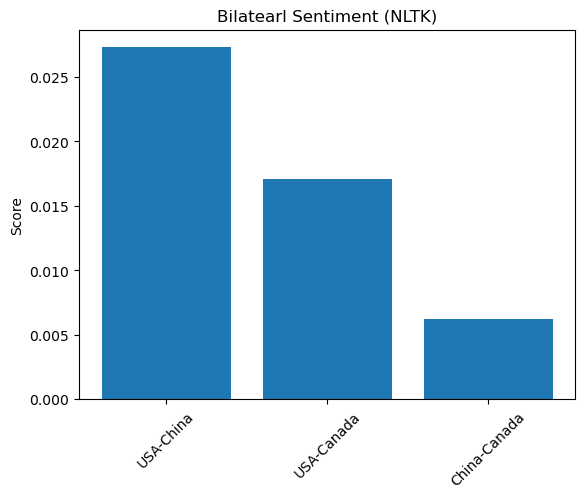

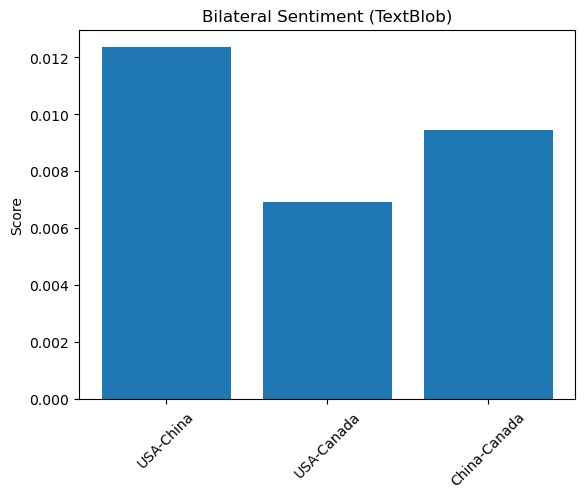

In [23]:
#graph sentiment and bilateral sentiment on bar graph
keys = list(bilateral_sentiment_scores_nltk.keys())
values = list(bilateral_sentiment_scores_nltk.values())

# Plot
plt.bar(keys, values)

# Add titles and labels
plt.title('Bilatearl Sentiment (NLTK)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

keys = list(bilateral_sentiment_scores_textblob.keys())
values = list(bilateral_sentiment_scores_textblob.values())

# Plot
plt.bar(keys, values)

# Add titles and labels
plt.title('Bilateral Sentiment (TextBlob)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

In [25]:
#get monthly tfidf values for each country relationship (one way)
def compute_monthly_tfidf_dict(df, tokenizer):
    monthly_tfidf = {}
    for month, group in df.groupby('Month'):
        #drop NaNs, grouped by month
        texts = group['Content'].dropna().tolist()
        if not texts:
            continue

        #use tf-idf vectorizer
        vectorizer = TfidfVectorizer(tokenizer = simple_tokenizer, token_pattern = None, ngram_range=(1,1))
        tfidf_matrix = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()   #get words
        tfidf_sum = tfidf_matrix.sum(axis=0)   #sum across all documents per month

        #create dictionary to store words and their tf-idf values
        tfidf_dict = {feature_names[i]: tfidf_sum[0, i] for i in range(len(feature_names))}
        monthly_tfidf[month] = tfidf_dict
    return monthly_tfidf

#compute monthly tfidf values
usa_china_tfidf = compute_monthly_tfidf_dict(usa_china_df, simple_tokenizer)
china_usa_tfidf = compute_monthly_tfidf_dict(usa_china_df, simple_tokenizer)
usa_canada_tfidf = compute_monthly_tfidf_dict(usa_canada_df, simple_tokenizer)
canada_usa_tfidf = compute_monthly_tfidf_dict(usa_canada_df, simple_tokenizer)
china_canada_tfidf = compute_monthly_tfidf_dict(china_canada_df, simple_tokenizer)
canada_china_tfidf = compute_monthly_tfidf_dict(china_canada_df, simple_tokenizer)

relations = [('USA-China', usa_china_tfidf, china_usa_tfidf),
             ('USA-Canada', usa_canada_tfidf, canada_usa_tfidf),
             ('China-Canada', china_canada_tfidf, canada_china_tfidf)]

In [27]:
#get monthly bilateral sentiment
monthly_bilateral_sentiment_nltk = defaultdict(dict)  # {month: {pair_name: score}}

for pair_name, tfidf_a, tfidf_b in relations:
    all_months = set(tfidf_a.keys()).union(set(tfidf_b.keys()))

    #compute sentiment by month, convert to bilateral sentiment by averaging
    for month in sorted(all_months):
        dict_a = tfidf_a.get(month)
        dict_b = tfidf_b.get(month)

        score_a = compute_overall_sentiment(dict_a) if dict_a else None
        score_b = compute_overall_sentiment(dict_b) if dict_b else None

        #checks case where one way sentiment does not exist for a country
        if score_a is not None and score_b is not None:
            combined_score = (score_a + score_b) / 2
        elif score_a is not None:
            combined_score = score_a
        elif score_b is not None:
            combined_score = score_b
        else:
            continue  # no data

        monthly_bilateral_sentiment_nltk[month][pair_name] = combined_score

#save as csv
rows = []
#loop on each month and dictionary of relations and monthly tf-idf value
for month, scores_dict in monthly_bilateral_sentiment_nltk.items():
    #loop on relation and get score for month
    for pair, score in scores_dict.items():
        rows.append({'Month': month, 'Relation': pair, 'Sentiment': score})

monthly_sentiment_df_nltk = pd.DataFrame(rows)
monthly_sentiment_df_nltk = monthly_sentiment_df_nltk.sort_values(['Month', 'Relation']).reset_index(drop = True)
print('Monthly sentiment (NLTK):')
print(monthly_sentiment_df_nltk)
print('')
#monthly_sentiment_df_nltk.to_csv("monthly_sentiment_nltk.csv", index = False)


#monthly bilateral sentiment with TextBlob
monthly_bilateral_sentiment_textblob = defaultdict(dict)  # {month: {pair_name: score}}
#get monthly bilateral sentiment
for pair_name, tfidf_a, tfidf_b in relations:
    all_months = set(tfidf_a.keys()).union(set(tfidf_b.keys()))

    #compute sentiment by month, convert to bilateral sentiment by averaging
    for month in sorted(all_months):
        dict_a = tfidf_a.get(month)
        dict_b = tfidf_b.get(month)

        score_a = compute_overall_sentiment_textblob(dict_a) if dict_a else None
        score_b = compute_overall_sentiment_textblob(dict_b) if dict_b else None

        #checks case where one way sentiment does not exist for a country
        if score_a is not None and score_b is not None:
            combined_score = (score_a + score_b) / 2
        elif score_a is not None:
            combined_score = score_a
        elif score_b is not None:
            combined_score = score_b
        else:
            continue  # no data

        monthly_bilateral_sentiment_textblob[month][pair_name] = combined_score

#save as csv
rows = []
#loop on each month and dictionary of relations and monthly tf-idf value
for month, scores_dict in monthly_bilateral_sentiment_textblob.items():
    #loop on relation and get score for month
    for pair, score in scores_dict.items():
        rows.append({'Month': month, 'Relation': pair, 'Sentiment': score})

monthly_sentiment_df_textblob = pd.DataFrame(rows)
monthly_sentiment_df_textblob = monthly_sentiment_df_textblob.sort_values(['Month', 'Relation']).reset_index(drop = True)
print('Monthly sentiment (Textblob):')
print(monthly_sentiment_df_textblob)
#monthly_sentiment_df_textblob.to_csv("monthly_sentiment_textblob.csv", index = False)

Monthly sentiment (NLTK):
      Month      Relation  Sentiment
0   2024-01  China-Canada  -0.032424
1   2024-01    USA-Canada   0.007185
2   2024-01     USA-China   0.071273
3   2024-02  China-Canada  -0.008471
4   2024-02    USA-Canada   0.006222
5   2024-02     USA-China   0.046718
6   2024-03  China-Canada  -0.049284
7   2024-03    USA-Canada   0.064931
8   2024-03     USA-China   0.079513
9   2024-04  China-Canada  -0.014640
10  2024-04    USA-Canada   0.048664
11  2024-04     USA-China   0.006797
12  2024-05  China-Canada   0.020213
13  2024-05    USA-Canada   0.028783
14  2024-05     USA-China   0.023514
15  2024-06  China-Canada  -0.022357
16  2024-06    USA-Canada   0.000000
17  2024-06     USA-China   0.012443
18  2024-07  China-Canada  -0.006569
19  2024-07    USA-Canada   0.012919
20  2024-07     USA-China   0.045415
21  2024-08  China-Canada  -0.042158
22  2024-08    USA-Canada   0.040612
23  2024-08     USA-China   0.035218
24  2024-09  China-Canada  -0.042958
25  2024-09 